In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from functools import partial
from plotly.subplots import make_subplots
import statsmodels.api as sm
import scipy.signal as signal

In [2]:
def distance_weighted(x, y, mu, eps=1e-3):
    if np.abs(np.sum(mu) - 1) > eps:
        raise ValueError("mu must sum to 1")
    return np.sum(np.array(mu) * (x - y) ** 2)

### Preprocessing

In [3]:
import pandas as pd
train_data = pd.read_csv('data/BATADAL/BATADAL_dataset04.csv')

In [4]:
train_data["DATETIME"] = pd.to_datetime(train_data["DATETIME"], format="%d/%m/%y %H")
train_data = train_data.set_index("DATETIME")

# add all the attacks for training set
train_data["atk_flag"] = 0

train_data.loc["2016-09-13 23:00":"2016-09-16 00:00", "atk_flag"] = 1
train_data.loc["2016-09-26 11:00":"2016-09-27 10:00", "atk_flag"] = 1
train_data.loc["2016-10-09 09:00":"2016-10-11 20:00", "atk_flag"] = 1
train_data.loc["2016-10-29 19:00":"2016-11-02 16:00", "atk_flag"] = 1
train_data.loc["2016-11-26 17:00":"2016-11-29 04:00", "atk_flag"] = 1
train_data.loc["2016-12-06 07:00":"2016-12-10 04:00", "atk_flag"] = 1
train_data.loc["2016-12-14 15:00":"2016-12-19 04:00", "atk_flag"] = 1

In [5]:
train_data["atk_flag"].value_counts()
df_np_label = train_data.drop([" ATT_FLAG", "atk_flag"], axis=1).values


In [24]:
# Remove timeseries that are constant on the whole time period.

train_data = train_data.loc[:, (train_data != train_data.iloc[0]).any()].copy()

In [25]:
def generate_subsequences(data, window_size, step_size):
    num_points, num_variables = data.shape
    number_subs = int((num_points - window_size)/step_size) + 1  # Number of subsequences

    subsequences = np.zeros((number_subs, window_size, num_variables))

    for i in range(number_subs):
        subsequences[i, :, :] = data[i*step_size:i*step_size+window_size, :]
    return subsequences

def reconstructed_loss(reconstructed_points, initial_points):
    return np.linalg.norm(reconstructed_points - initial_points, ord=2, axis=1)


In [26]:
window_size = 20
stride = 5
sequences = generate_subsequences(df_np_label, window_size, stride)
label_sequences = generate_subsequences(
    train_data["atk_flag"].values.reshape(-1, 1), window_size, stride
)

In [27]:
sequences_acf = np.zeros_like(sequences)

In [29]:
sequences_copy = sequences.copy()

for i in range(sequences_copy.shape[0]):
    for j in range(sequences_copy.shape[2]):

        # check if all values are the same
        if np.all(sequences_copy[i, :, j] == sequences_copy[i, 0, j]):
            sequences_copy[i, 0, j] += 0.0001
            # print("warning: constant timeseries")
            
        sequences_acf[i, :, j] = sm.tsa.acf(
            sequences_copy[i, :, j], nlags=len(sequences_copy[i, :, j]) - 1
        )

# sequences_acf[np.isnan(sequences_acf)] = sequences[np.isnan(sequences_acf)]

In [30]:
data_for_clustering = sequences.reshape(sequences.shape[0], -1)
data_for_clustering_shapes = sequences_acf.reshape(sequences_acf.shape[0], -1)

In [38]:
px.imshow(train_data.drop(columns=["atk_flag", " ATT_FLAG"]).corr(), width=600, height=600, title="correlation matrix")

#### Fuzzy C-Means on amplitude using naive mu

In [39]:
mu = [1 / data_for_clustering.shape[1] for i in range(data_for_clustering.shape[1])]

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data_for_clustering.T,
    3, # N cluster
    2, # jsp
    metric=partial(distance_weighted, mu=mu),
    error=0.005,
    maxiter=1000,
    init=None,
)

# Reconstruction of initial points
reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

In [40]:
loss = reconstructed_loss(reconstructed_points, data_for_clustering)


In [41]:
label_reshaped = np.max(label_sequences, axis=1)
# Select points with label 1
label_1_indices = np.where(label_reshaped == 1)[0]

In [42]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(loss)), y=loss, mode="lines", name="Loss"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=loss[label_1_indices], mode="markers", name="Attack"
    )
)

fig

#### Fuzzy C-means on shapes with ACF

In [43]:
mu = [
    1 / data_for_clustering_shapes.shape[1]
    for i in range(data_for_clustering_shapes.shape[1])
]

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data_for_clustering_shapes.T,
    3,  # N cluster
    2,  # jsp
    metric=partial(distance_weighted, mu=mu),
    error=0.005,
    maxiter=1000,
    init=None,
)

# Reconstruction of initial points
reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

In [44]:
loss = reconstructed_loss(reconstructed_points, data_for_clustering_shapes)

In [45]:
label_reshaped = np.max(label_sequences, axis=1)
# Select points with label 1
label_1_indices = np.where(label_reshaped == 1)[0]

In [46]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(loss)), y=loss, mode="lines", name="Loss"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=loss[label_1_indices], mode="markers", name="Attack"
    )
)

fig

### Ploting the signal and attack points

In [364]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

window_analysis = slice("2016-09-11 23:00", "2016-09-19 00:00")

fig.add_trace(
    go.Scatter(
        x=train_data[window_analysis].index,
        y=train_data[window_analysis][" L_T7"],
        mode="lines",
        name="L_T7",
    )
)

fig.add_trace(
    go.Scatter(
        x=train_data[window_analysis].index,
        y=train_data[window_analysis]["atk_flag"],
        mode="lines",
        name="atk_flag",
    ),
    secondary_y=True,
)


fig

In [365]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=train_data.index,
        y=train_data[" L_T7"],
        mode="lines",
        name="L_T7",
    )
)


fig.add_trace(
    go.Scatter(
        x=train_data.index,
        y=train_data[" L_T1"],
        mode="lines",
        name="L_T1",
    )
)

fig.add_trace(
    go.Scatter(
        x=train_data.index,
        y=train_data[" L_T4"],
        mode="lines",
        name="L_T4",
    )
)


fig.add_trace(
    go.Scatter(
        x=train_data.index,
        y=train_data["atk_flag"],
        mode="lines",
        name="ATT FLAG",
    ),
    secondary_y=True,
)


fig

### Optimization

#### Particule Swarm Optimization

#### Genetic Algorithm parallel

In [74]:
# !pip install pygad

In [82]:
import pygad

In [83]:
function_inputs = [0.1]* (data_for_clustering.shape[1] // window_size)
desired_output = 10000

In [100]:
def obj_func(ga_instance, solution, solution_idx):
    win_len = data_for_clustering.shape[1] // len(solution)

    mu = np.repeat(solution, win_len)
    mu = mu / mu.sum()  # normalize the coefficients

    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        data_for_clustering.T, # data_for_clustering is global !
        3,
        2,
        metric=partial(distance_weighted, mu=mu),
        error=0.005,
        maxiter=1000,
        init=None,
    )

    # Reconstruction of initial points
    reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]
    loss = reconstructed_loss(reconstructed_points, data_for_clustering)

    return - loss.sum()

In [128]:
fitness_function = obj_func

num_generations = 20
num_parents_mating = 4

sol_per_pop = 8
num_genes = len(function_inputs)

gene_space = np.tile(np.linspace(0, 1, 100), num_genes).reshape(num_genes, -1)

parent_selection_type = "sss"
keep_parents = -1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

In [129]:
def on_gen(ga_instance):
    print("Generation : ", ga_instance.generations_completed)
    print("Fitness of the best solution :", ga_instance.best_solution()[1])

In [130]:
ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    gene_space=gene_space,
    parent_selection_type=parent_selection_type,
    keep_parents=keep_parents,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    on_generation=on_gen,
    # parallel_processing=["process", 5], # 5 is the number of parallel processes, otherwise int 5 or None
)

In [131]:
ga_instance.run()

Generation :  1
Fitness of the best solution : -143210.09547056377
Generation :  2
Fitness of the best solution : -143176.78460214153
Generation :  3
Fitness of the best solution : -143178.35566753062
Generation :  4
Fitness of the best solution : -143054.36636521877
Generation :  5
Fitness of the best solution : -142967.75787096267
Generation :  6
Fitness of the best solution : -142827.71864620113
Generation :  7
Fitness of the best solution : -142827.6651732235
Generation :  8
Fitness of the best solution : -142669.90902075171
Generation :  9
Fitness of the best solution : -142269.59332125244
Generation :  10
Fitness of the best solution : -142205.3698383021
Generation :  11
Fitness of the best solution : -142205.4030210717
Generation :  12
Fitness of the best solution : -142205.4030210717
Generation :  13
Fitness of the best solution : -142205.4030210717
Generation :  14
Fitness of the best solution : -142121.25748631643
Generation :  15
Fitness of the best solution : -142120.694062

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


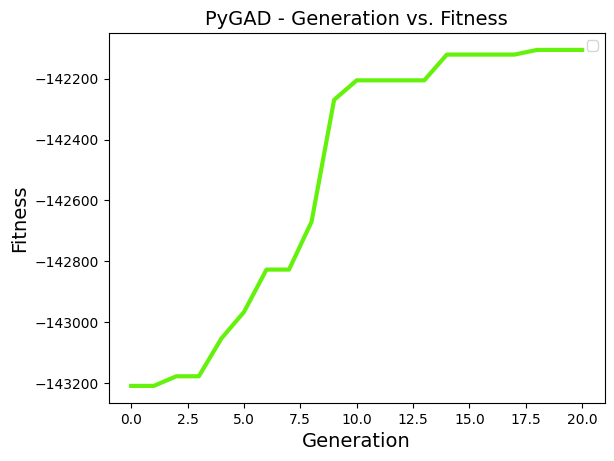

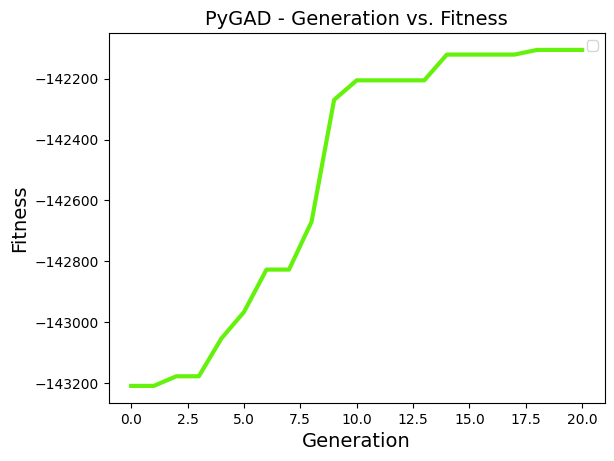

In [132]:
ga_instance.plot_fitness()

In [133]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [0.21212121 0.11111111 0.50505051 0.1010101  0.65656566 0.58585859
 0.07070707 0.13131313 0.07070707 0.16161616 0.56565657 0.15151515
 0.04040404 0.82828283 0.62626263 0.19191919 0.04040404 0.72727273
 1.         0.09090909 0.41414141 0.27272727 0.57575758 0.38383838
 0.95959596 0.04040404 0.3030303  0.03030303 0.98989899 0.39393939
 0.06060606 0.02020202 0.2020202  0.92929293 0.37373737 0.87878788
 0.39393939 0.62626263 0.22222222 0.43434343 0.24242424 0.50505051
 0.18181818]
Fitness value of the best solution = -142105.39338599576


#### Genetic Algorithm no parallel

In [47]:
# !pip install geneticalgorithm

from geneticalgorithm import geneticalgorithm as ga

In [48]:
model = "amplitude a azda"

if model == "amplitude":
    data_for_clustering_opt = data_for_clustering

else:
    data_for_clustering_opt = data_for_clustering_shapes

In [61]:
def objective_function(data_for_clustering: np.ndarray, list_mu: np.ndarray):
    # list_mu shape = dim

    win_len = data_for_clustering.shape[1] // len(list_mu)

    mu = np.repeat(list_mu, win_len)
    mu = mu / mu.sum()  # normalize the coefficients

    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        data_for_clustering.T,
        4,
        2,
        metric=partial(distance_weighted, mu=mu),
        error=0.005,
        maxiter=1000,
        init=None,
    )

    # Reconstruction of initial points
    reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]
    loss = reconstructed_loss(reconstructed_points, data_for_clustering)

    return loss.sum()

In [62]:
dim = data_for_clustering_opt.shape[1] // window_size

In [63]:
objective_function(
    data_for_clustering_opt,
    np.array([1 / data_for_clustering_opt.shape[1] for i in range(dim)]),
)

145827.06695637747

In [64]:
varbound = np.array([[0, 1]] * dim)

In [65]:
algorithm_param = {
    "max_num_iteration": 20,
    "population_size": 20,
    "mutation_probability": 0.1,
    "elit_ratio": 0.05,
    "crossover_probability": 0.5,
    "parents_portion": 0.3,
    "crossover_type": "uniform",
    "max_iteration_without_improv": None,
}

 The best solution found:                                                                           
 [0.35901202 0.9626676  0.93600016 0.81860251 0.23279273 0.25107557
 0.0342155  0.79119962 0.98686049 0.01516042 0.31229484 0.50984973
 0.90210353 0.11666396 0.05411359 0.77909757 0.47219519 0.15289006
 0.21422945 0.81488872 0.03878475 0.41372463 0.15968331 0.08181299
 0.6173369  0.47726302 0.32640351 0.56966875 0.69542528 0.8876542
 0.23543549 0.70016325 0.84898647 0.97750535 0.2237755  0.60615059
 0.70213499 0.10987747 0.41871313 0.36078938 0.04010666 0.1335297
 0.35991148]

 Objective function:
 2252.5612948216376


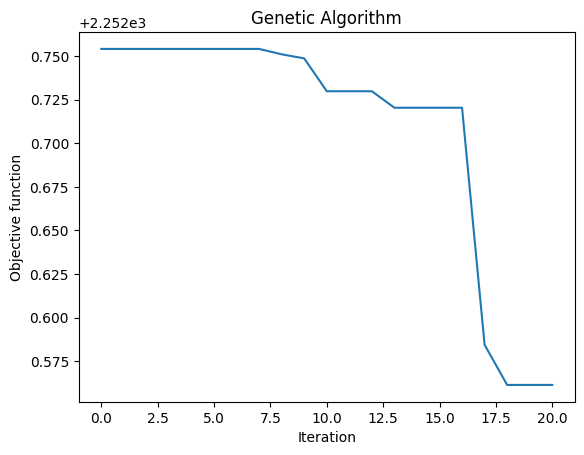

In [66]:
model = ga(
    function=partial(objective_function, data_for_clustering_opt),
    dimension=dim,
    variable_type="real",
    variable_boundaries=varbound,
    algorithm_parameters=algorithm_param,
    function_timeout=100,
)

model.run()

In [55]:
convergence = model.report
solution = model.output_dict

In [390]:
# naive : 153995.66723152378

In [56]:
solution

{'variable': array([0.29028316, 0.44290858, 0.73369819, 0.08813788, 0.03312121,
        0.10516601, 0.6165482 , 0.94903784, 0.65097833, 0.00426991,
        0.39555209, 0.97077055, 0.70439481, 0.95377199, 0.13391967,
        0.21415527, 0.86023732, 0.15064851, 0.00794351, 0.687986  ,
        0.07598132, 0.00223703, 0.31762701, 0.34007799, 0.45282425,
        0.07867696, 0.54635291, 0.78012857, 0.04225124, 0.71242644,
        0.36039418, 0.03698204, 0.84567714, 0.9653901 , 0.79799653,
        0.02870408, 0.21401585, 0.34339442, 0.07025733, 0.28121225,
        0.77536207, 0.63262561, 0.04791961]),
 'function': 2252.7521191025503}

### Use the optimization result to run the reconstruction loss

In [67]:
opt_mu = solution["variable"]
win_len = data_for_clustering_opt.shape[1] // len(opt_mu)

opt_mu = np.repeat(opt_mu, win_len)
opt_mu = opt_mu / opt_mu.sum()  # normalize the coefficients

In [68]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_for_clustering_opt.T,
    3, # N cluster
    2, # jsp
    metric=partial(distance_weighted, mu=opt_mu),
    error=0.005,
    maxiter=1000,
    init=None,
)

# Reconstruction of initial points
opt_reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

In [69]:
opt_loss = reconstructed_loss(opt_reconstructed_points, data_for_clustering_opt)

In [70]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(opt_loss)), y=opt_loss, mode="lines", name="Loss"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=opt_loss[label_1_indices], mode="markers", name="Attack"
    )
)

fig